## Pycytominer example pipeline
requires scipy=<1.7.3


In [1]:
import pandas as pd
from pycytominer import aggregate
from pycytominer import annotate
from pycytominer import consensus
from pycytominer import feature_select
from pycytominer import normalize

# Import these for plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
import umap

#### Run the preprocessing pipeline

In [2]:
BaseDir = "./results/"

In [3]:
# Import feature data after QC
df = pd.read_csv("{}colo44_QC_filtered_Median.csv".format(BaseDir), sep=";", index_col=0)
# df.head(1)

In [116]:
# # Import feature data after QC
# df = pd.read_csv("{}colo44_QC_filtered_MedianAndMADAndAreaOccupied.csv".format(BaseDir), sep=";", index_col=0)
# # df.head(1)

In [4]:
ListOfData = list(df.columns.values)

# Remove non-data features from the list of features
ListOfFeatures = list(set(ListOfData) - set(['plate_well', 'ImageID']))

In [5]:
# Import Metadata
dfLayout = pd.read_csv("colopaint44-v3-metadata.csv", sep=",")
dfLayout.head()

,layout_id,well_id,plate_well,cmpd,batch_id,solvent,stock_conc,stock_conc_unit,cmpd_vol,cmpd_vol_unit,...,pert_type,cmpd_conc,cmpd_conc_unit,batchid,cbkid,libid,libtxt,moa,clinical_status,class
0,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B02,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B02,[tetr],PHB000015,dmso,10.0,mM,7.5,nL,...,poscon,2.50000,uM,PHB000015,[tetr],[tetr],pharmb_io,NaN,NaN,NaN
1,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B03,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B03,SN-38,BJ1835885,dmso,0.1,mM,2.5,nL,...,trt,0.00833,uM,BJ1835885,SN-38,CBK290251,Tocris_known_screen_mini,topoisomerase inhibitor,launched,targeted
2,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B04,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B04,regora,BJ1827053,dmso,0.1,mM,2.5,nL,...,trt,0.00833,uM,BJ1827053,regorafenib,CBK278025,KDex_known_kinase_inhibitors,FGFR inhibitor|KIT inhibitor|PDGFR tyrosine ki...,launched,targeted
3,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B05,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B05,[dmso],PHB000001,dmso,100.0,perc,30.0,nL,...,negcon,0.10000,perc,PHB000001,[dmso],[dmso],compound_center,NaN,NaN,NaN
4,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B06,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B06,cobime,BJ1897191,dmso,0.1,mM,30.0,nL,...,trt,0.10000,uM,BJ1897191,cobimetinib,CBK303945,SLL_repurposing_set_SPECS,MEK inhibitor,launched,targeted


In [6]:
# Aggregate: calculate well averages
population_df = aggregate(df, strata="plate_well", features = ListOfFeatures, operation = "mean", output_file="none", compute_object_count=False)

well identifier accross plates = strata = 'plate_well'

In [7]:
# Annotate: connect metadata to the feature data
# OBS: metadata will be prefixed with 'Metadata_'
annotated = annotate(population_df, platemap=dfLayout, join_on=["Metadata_plate_well", "plate_well"],add_metadata_id_to_platemap=True, format_broad_cmap=False, clean_cellprofiler=False)
annotated["Metadata_plate_well"] = annotated["Metadata_layout_id"] + "_" + annotated["Metadata_well_id"] # Keep this collumn


In [121]:
# # SKIP AGGREGATION
# # Annotate: connect metadata to the feature data
# # OBS: metadata will be prefixed with 'Metadata_'
# annotated = annotate(df, platemap=dfLayout, join_on=["Metadata_plate_well", "plate_well"],add_metadata_id_to_platemap=True, format_broad_cmap=False, clean_cellprofiler=False)

In [8]:
# Normalize: choose between standardize, robustize, mad_robustize, spherize 
normalized = normalize(annotated, features=ListOfFeatures,image_features=False, meta_features="infer", samples="Metadata_pert_type == 'negcon'", method="standardize")

In [9]:
# Feature selection: "variance_threshold", "correlation_threshold", "drop_na_columns", "blocklist", "drop_outliers", "noise_removal",
selected_df = feature_select(normalized, features=ListOfFeatures, operation=["correlation_threshold", "blocklist","drop_outliers"])

In [10]:
# Remove non-data features from the list
ListOfSelectedFeatures = list(selected_df.columns.values)
ListOfMetadata = list(selected_df.columns[selected_df.columns.str.contains("Metadata_")])
ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

In [ ]:
# Concensus data: average across replicates
# My replicates are those of the same concentration, and same compound.
consensus_df = consensus(selected_df, features=ListOfSelectedFeatures, replicate_columns= ["Metadata_cmpd", "Metadata_cmpd_conc"], operation= "mean")

In [ ]:
selected_df.to_csv("{}/colopaint44_selected_data_notMAD.csv".format(BaseDir), sep=";")

In [99]:
# for Morpheus
# morpheus_df = selected_df.drop(list(['Metadata_smiles', 'Metadata_inchi','Metadata_inkey']), axis=1)
# morpheus_df['Metadata_cmpd_conc'].loc[(morpheus_df['Metadata_cmpd'] == '[dmso]')] = 100
# morpheus_df.to_csv("{}/colopaint44_for_morpheus.csv".format(BaseDir), sep=",")

#### Viability

In [ ]:
# Remove the reference compounds for now
dfPert = annotated[(annotated.Metadata_pert_type == 'poscon') | (annotated.Metadata_pert_type == 'trt')]
dfDMSO = annotated[annotated.Metadata_cmpd == '[dmso]']

In [ ]:
# These features represent cell viability 
# note that nuclei are counted twice: 1) Count_nuclei is measured in the QC pipeline 2) ObjectNumber_nuclei is measured in the main pipeline
ListOfViability = ['Count_nuclei', 'ObjectNumber_cells', 'ObjectNumber_nuclei', 'AreaOccupied_AreaOccupied_cells']


In [ ]:
dfViability = ((dfPert[ListOfViability] / dfDMSO[ListOfViability].mean()) * 100)
dfViability = dfViability.join(dfPert[ListOfMetadata])
dfViability.to_csv("{}/viability_scores.csv".format(BaseDir), sep=",")

#### The data is preprocessed, time to plot

from Maris: PCA

In [11]:
df_toplot = selected_df

In [81]:
pca = PCA(n_components=4)
x = df_toplot.loc[:, ListOfSelectedFeatures[:]].values 
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents)
principalDf.rename(
    columns={
        0: "principal component 1",
        1: "principal component 2",
        2: "principal component 3",
        3: "principal component 4",
    },
    inplace=True,
)

In [82]:
# Attach the metadata again
principalDf = principalDf.merge(
    selected_df[ListOfMetadata],
    left_index=True,
    right_index=True,
)

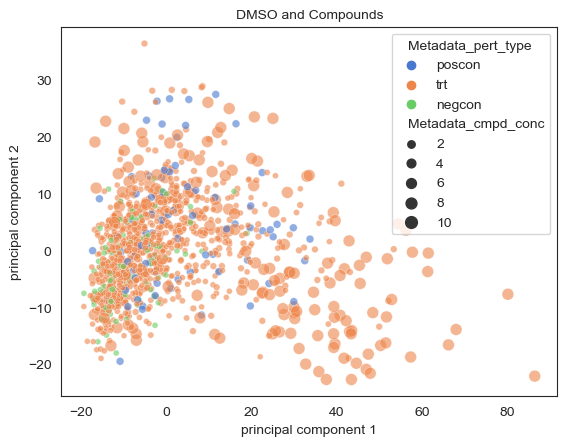

In [83]:
# One of many possible plots
fig = plt.figure()
ax = sns.scatterplot(
    x="principal component 1",
    y="principal component 2",
    hue='Metadata_pert_type',
    data=principalDf,
    size="Metadata_cmpd_conc",
    palette='muted',
    alpha=(0.6),
    marker="o",
    #legend=False
    )
ax.set_title("DMSO and Compounds", fontsize=10)
ax.set_facecolor("w")

#### Only positive controls

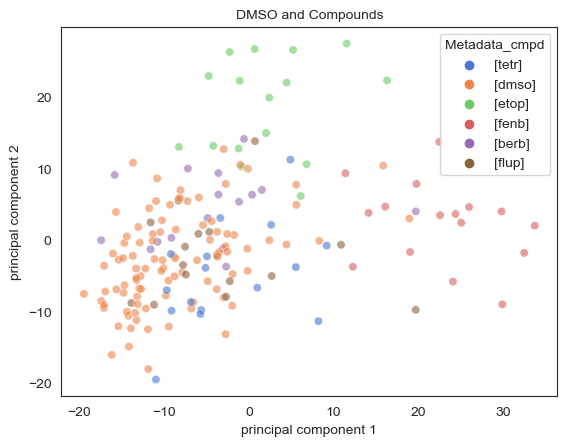

In [84]:
# PCA
fig = plt.figure()
ax = sns.scatterplot(
    x="principal component 1",
    y="principal component 2",
    hue='Metadata_cmpd',
    data=principalDf[principalDf['Metadata_pert_type'] != 'trt'],
    #size="Metadata_cmpd_conc",
    palette='muted',
    alpha=(0.6),
    marker="o",
    #legend=False
    )
ax.set_title("DMSO and Compounds", fontsize=10)
ax.set_facecolor("w")

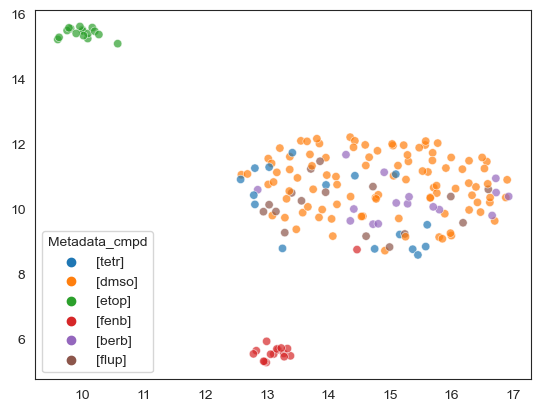

In [17]:
## UMAP
posconDf = df_toplot[df_toplot['Metadata_pert_type'] != 'trt'] # Only take positive controls
training_data = posconDf.loc[:, ListOfSelectedFeatures[:]].values 

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist= 0.1, random_state=42)
embedding = reducer.fit_transform(training_data)

fig = plt.figure()
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=posconDf.Metadata_cmpd,
    alpha=(0.7),
    marker="o",
    #legend=False
    )


### Per concetration

In [56]:
ConcList = sorted(list(set(df_toplot["Metadata_cmpd_conc"])))
ConcList.remove(2.5)

df_toplot['Metadata_cmpd_conc'].loc[(df_toplot['Metadata_cmpd'] == '[dmso]')] = 100

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_29463/2321609171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toplot['Metadata_cmpd_conc'].loc[(df_toplot['Metadata_cmpd'] == '[dmso]')] = 100


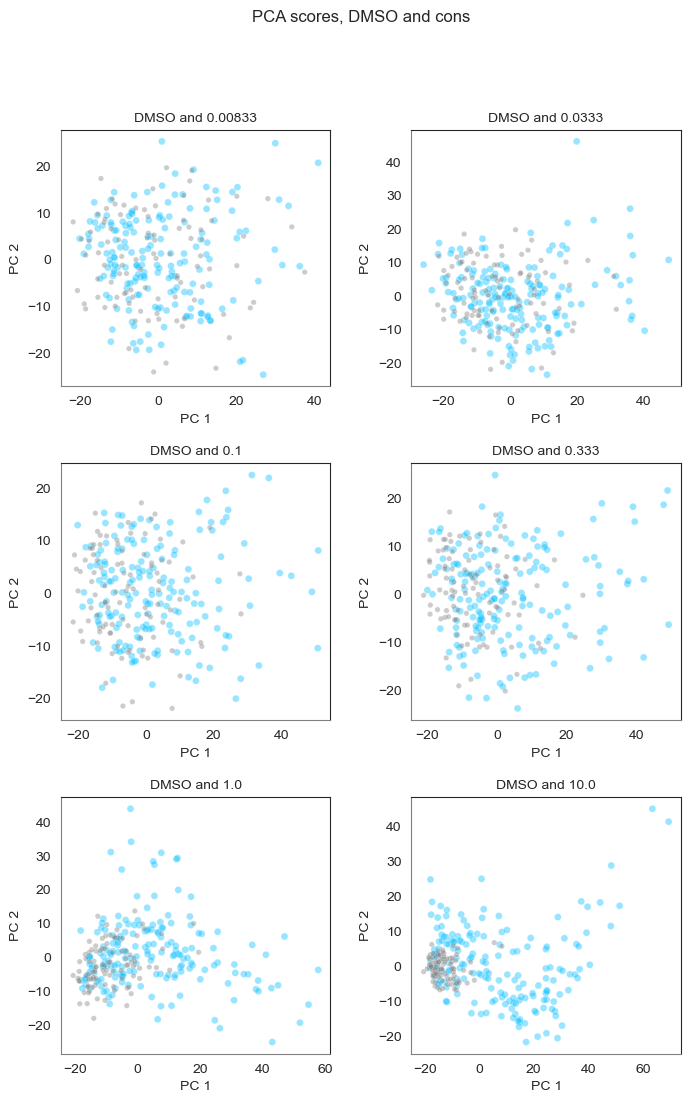

In [57]:
nrrow = 3
nrcol = 2
colors = ["deepskyblue", "gray"]

fig = plt.figure(figsize=(8, 12))
sp = 1
for conc in ConcList:
    dfOneCompound = df_toplot.loc[
        ((df_toplot["Metadata_cmpd_conc"] == conc)), ["Metadata_cmpd", "Metadata_cmpd_conc"] + ListOfSelectedFeatures
    ]
    dfDMSO = df_toplot.loc[
        ((df_toplot["Metadata_cmpd"] == "[dmso]")), ["Metadata_cmpd", "Metadata_cmpd_conc"] + ListOfSelectedFeatures
    ]
    frames = [dfOneCompound, dfDMSO]
    dfOneCompoundandDMSO = pd.concat(frames)
    dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)

    x = dfOneCompoundandDMSO.loc[:, ListOfSelectedFeatures[:]].values
    pca = PCA(n_components=3)
    x = StandardScaler().fit_transform(x)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents)
    principalDf.rename(
        columns={
            0: "principal component 1",
            1: "principal component 2",
            2: "principal component 3",
        },
        inplace=True,
    )
    principalDf = principalDf.merge(
        dfOneCompoundandDMSO[["Metadata_cmpd", "Metadata_cmpd_conc"]], left_index=True, right_index=True
    )
    # principalDf.to_csv('{}/PCA_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_xlabel("PC 1", fontsize=10)
    ax.set_ylabel("PC 2", fontsize=10)
    ax.spines["left"].set_color("grey")
    ax.spines["bottom"].set_color("grey")
    x
    ax = sns.scatterplot(
        x="principal component 1",
        y="principal component 2",
        hue="Metadata_cmpd_conc",
        data=principalDf,
        palette=colors,
        size="Metadata_cmpd_conc",
        sizes=(25, 15),
        alpha=(0.4),
        marker="o",
    )

    ax.set_title("DMSO and {}".format(conc), fontsize=10)
    ax.set_facecolor("w")
    ax.get_legend().remove()
    sp += 1
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle("PCA scores, DMSO and cons".format(), fontsize=12)
#fig.savefig(
#    "{}/PCA_DMSOandCons.{}".format(OutputDir, figformat), dpi=dpi, bbox_inches="tight"
#)
plt.show()


## TODO: 
* UMAP 
* Visualize MOA's 
* Clinical stage
* Targeted / untargeted 
* cytotoxic / cytostatic ? 
* PCA per compound at different concentrations
* Not sure if blocklist features are taken out ... --> They are not for the MAD features. 
